In [138]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [535]:
from datasets.density_datasets import Datasets as DensityDatasets
import numpy as np

X, l = DensityDatasets.aggregation.standardized_data_cached

In [536]:
from src.Cluster.DPC.cluster import DensityPeakCluster
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

l_dpc = DensityPeakCluster(anormal=False).fit(X).labels_
l_hdbscan = HDBSCAN().fit(X).labels_

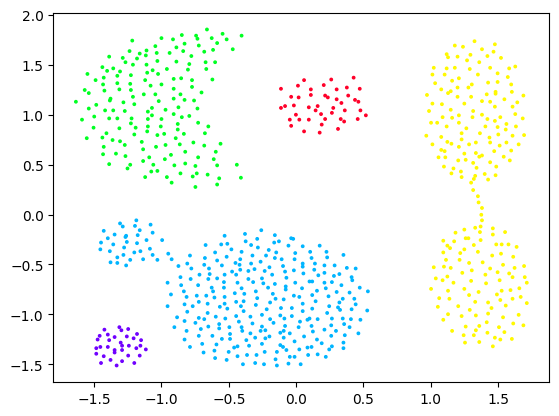

In [539]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    return colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )

cmap = truncate_colormap(plt.colormaps["gist_rainbow"], 0.0, 0.85)
plt.scatter(X[:, 0], X[:, 1], s=3, c=l_hdbscan, cmap=cmap)
plt.show()

In [538]:
from src.Evaluation import disco_score

disco_score(X, l), disco_score(X, l_dpc), disco_score(X, l_hdbscan)

(0.3056510576364597, 0.5138099180630531, 0.669704899865715)

In [540]:
len(set(l))

7

In [553]:
from src.Evaluation.dcdistances.dctree import DCTree

dctree = DCTree(X, min_points=5, min_points_mr=5)

k = len(set(l))
k = 6

eps = dctree.get_eps_for_k(k)
l_dbscan = DBSCAN(eps).fit(X).labels_
l_kcenter = dctree.get_k_center(k)
print(set(l_dbscan), set(l_kcenter))

{0, 1, 2, 3, 4, 5, -1} {0, 1, 2, 3, 4, 5, -1}


In [554]:
from sklearn.metrics import adjusted_rand_score as ARI, normalized_mutual_info_score as NMI

ARI(l_dbscan, l_kcenter), NMI(l_dbscan, l_kcenter)

(0.9659093299475898, 0.9473650706715875)

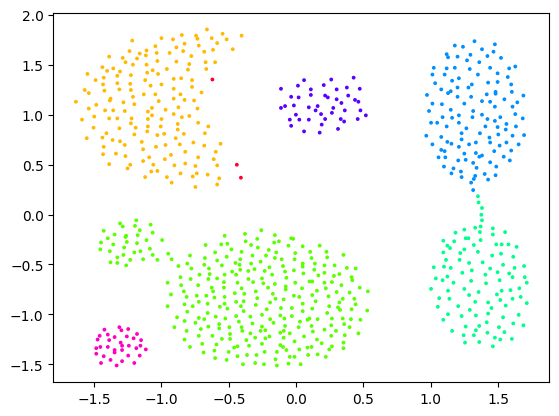

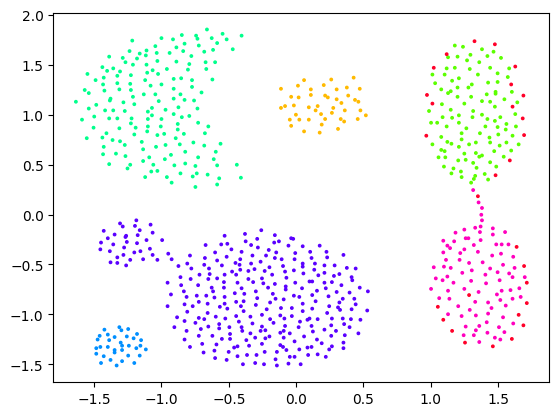

In [555]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], s=3, c=l_dbscan, cmap="gist_rainbow")
plt.show()

plt.scatter(X[:, 0], X[:, 1], s=3, c=l_kcenter, cmap="gist_rainbow")
plt.show()

In [478]:
from src.Evaluation.dcdistances.dctree import DCTree
from src.utils.cluster_algorithms import optimal_k_dbscan

X, l = DensityDatasets.aggregation.standardized_data_cached

l_ = optimal_k_dbscan(X, l)
set(l_)

1.0


{0, 1, 2, 3, 4}

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], s=3, c=l_, cmap="gist_rainbow")
plt.show()

In [507]:
import pandas as pd
from src.utils.plots import plot_datasets
from ast import literal_eval
from itertools import product
from src.utils.cluster_algorithms import CLUSTER_ALGORITHMS
import matplotlib.pyplot as plt
import matplotlib.colors as colors

DISCO_ROOT_PATH = "/export/share/pascalw777dm/DISCO"

def load_clustering(args):
    dataset, clusterer, run = args
    X, l = dataset.standardized_data_cached

    np.random.seed(0)
    seeds = np.random.choice(10_000, size=run + 1, replace=False)
    np.random.seed(seeds[-1])
    shuffle_data_index = np.random.choice(len(X), size=len(X), replace=False)
    X = X[shuffle_data_index]

    df = pd.read_csv(
        f"{DISCO_ROOT_PATH}/clusterings/density_standardized/{dataset.id}/{clusterer}_{run}.csv"
    )
    l_ = df["value"][0]
    l_ = np.array(literal_eval(",".join(l_.split()).replace("[,", "[")))

    return X, l_

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

cmap = truncate_colormap(plt.colormaps["gist_rainbow"], 0.0, 0.85)

def plot_clusterings(dataset):
    clusterer = list(CLUSTER_ALGORITHMS.keys())
    datasets = list(product([dataset], clusterer, [0]))
    clusterings = list(map(load_clustering, datasets))
    clusterings = [[clustering] for clustering in clusterings]
    return plot_datasets(clusterings, list(CLUSTER_ALGORITHMS.keys()), n_rows=2, cmap=cmap)

In [ ]:
for dataset in DensityDatasets:
    print(dataset.name)
    plot_clusterings(dataset)
    # plt.savefig(f"imgs/clusterings/{dataset.id}.png", bbox_inches='tight', pad_inches=0)
    plt.show()

In [131]:
### DISCO Results to normal format

import os
import glob
from ast import literal_eval

ari_path = "clustering_results/density_standardized/"
new_path = "clustering_results2/density_standardized/"

def restructer_clustering_results(path, new_path):
    for file_path in glob.glob(f"{path}*/*"):
        folders = file_path.split("/")
        dataset, clusterer, run = literal_eval(folders[-2])
        new_file_path = f"{new_path}{dataset}/{clusterer}_{run}.csv"
        os.makedirs(os.path.dirname(new_file_path), exist_ok=True)
        df = pd.read_csv(file_path)
        df["function"] = df["dataset"].apply(lambda args: literal_eval(args)[1])
        df["dataset"] = df["dataset"].apply(lambda args: literal_eval(args)[0])
        df.to_csv(new_file_path, index=False, na_rep='nan')

restructer_clustering_results(ari_path, new_path)

In [534]:
### ARI Calculation

import pandas as pd
import numpy as np
from datasets.density_datasets import Datasets as DensityDatasets
from src.utils.cluster_algorithms import CLUSTER_ALGORITHMS
from sklearn.metrics import adjusted_rand_score as ARI

DISCO_ROOT_PATH = "/export/share/pascalw777dm/DISCO"
runs = 10

def calculate_ari(args):
    dataset, clusterer, run = args
    X, l = dataset.standardized_data_cached

    np.random.seed(0)
    seeds = np.random.choice(10_000, size=run + 1, replace=False)
    np.random.seed(seeds[-1])
    shuffle_data_index = np.random.choice(len(X), size=len(X), replace=False)
    X = X[shuffle_data_index]
    l = l[shuffle_data_index]

    df = pd.read_csv(f"{DISCO_ROOT_PATH}/clusterings/density_standardized/{dataset.id}/{clusterer}_{run}.csv")
    l_ = df["value"][0]
    l_ = np.array(literal_eval(",".join(l_.split()).replace("[,", "[")))

    df.loc[0, "value"] = ARI(l, l_)
    ari_path = f"{DISCO_ROOT_PATH}/results/ari/density_standardized/{dataset.id}/{clusterer}_{run}.csv"
    os.makedirs(os.path.dirname(ari_path), exist_ok=True)
    df.to_csv(ari_path, index=False, na_rep="nan")

datasets = list(product(DensityDatasets, list(CLUSTER_ALGORITHMS.keys()), range(runs)))
clusterings = list(map(calculate_ari, datasets))